In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import string

import matplotlib
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from nltk.corpus import stopwords
from pymongo import MongoClient
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    plot_roc_curve,
    precision_score,
    recall_score,
)
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.naive_bayes import MultinomialNB


sns.set_theme()

In [14]:
data = pd.read_json('Movies_and_TV_5.json', lines=True)

NameError: name 'one_star_reviews' is not defined

In [108]:

from pymongo import MongoClient

client = MongoClient('localhost', 27017)
db = client['amazon_reviews']
reviews = db['reviews']
reviews_cleaned = db['reviews_cleaned']

In [16]:
#for row_num in range(data.shape[0]):
#    row = (data.iloc[row_num])
#    reviews.insert_one({'reviewerID': str(row['reviewerID']), 'asin':str(row['asin']), 'reviewerName':row['reviewerName'], 'reviewText': row['reviewText'], 'helpful':row['helpful'], 'overall':str(row['overall']), 'summary':row['summary'], 'unixReviewTime':str(row['unixReviewTime']), 'reviewTime':row['reviewTime']})

In [3]:
df = pd.DataFrame(reviews.find({}))

In [70]:
df['review_char_length'] = df['reviewText'].apply(len)

In [73]:
df['stars'] = df['overall'].apply(lambda x: int(x))

In [76]:
one_star_reviews = df[df['stars'] == 1]
two_star_reviews = df[df['stars'] == 2]
three_star_reviews = df[df['stars'] == 3]
four_star_reviews =df[df['stars'] == 4]
five_star_reviews = df[df['stars'] == 5]

In [98]:
df

,_id,reviewerID,asin,reviewerName,reviewText,helpful,overall,summary,unixReviewTime,reviewTime,review_char_length,stars
0,607d8d6e4430169e4d014ccc,ADZPIG9QOCDG5,0005019281,"Alice L. Larson ""alice-loves-books""",This is a charming version of the classic Dick...,"[0, 0]",4,good version of a classic,1203984000,"02 26, 2008",299,4
1,607d8d6e4430169e4d014ccd,A35947ZP82G7JH,0005019281,Amarah Strack,It was good but not as emotionally moving as t...,"[0, 0]",3,Good but not as moving,1388361600,"12 30, 2013",122,3
2,607d8d6e4430169e4d014cce,A3UORV8A9D5L2E,0005019281,Amazon Customer,"Don't get me wrong, Winkler is a wonderful cha...","[0, 0]",3,Winkler's Performance was ok at best!,1388361600,"12 30, 2013",251,3
3,607d8d6e4430169e4d014ccf,A1VKW06X1O2X7V,0005019281,"Amazon Customer ""Softmill""",Henry Winkler is very good in this twist on th...,"[0, 0]",5,It's an enjoyable twist on the classic story,1202860800,"02 13, 2008",153,5
4,607d8d6e4430169e4d014cd0,A3R27T4HADWFFJ,0005019281,BABE,This is one of the best Scrooge movies out. H...,"[0, 0]",4,Best Scrooge yet,1387670400,"12 22, 2013",148,4
...,...,...,...,...,...,...,...,...,...,...,...,...
1697528,607d94294430169e4d1b33c4,AV657BUYHHXZ2,B00LT1JHLW,"Mike Rules ""Mike""",wow $269.99 for the entire series on Blu Ray??...,"[1, 14]",1,Way to Expensive!! WB = GREED,1406073600,"07 23, 2014",474,1
1697529,607d94294430169e4d1b33c5,A17W587EH23J0Q,B00LT1JHLW,"Ron2900 ""Ron""","Finally, the holy grail of tv-on-dvd boxsets i...","[32, 48]",5,"HOLY BAT-BOXSET, BATMAN... I never thought thi...",1405641600,"07 18, 2014",769,5
1697530,607d94294430169e4d1b33c6,A3DE438TF1A958,B00LT1JHLW,thomas henry,Could this be a true or I'm i dreaming batman ...,"[3, 10]",5,prayers have been answered because batman 60s ...,1405728000,"07 19, 2014",538,5
1697531,607d94294430169e4d1b33c7,A2RWCXDMANY0LW,B00LT1JHLW,wheev,I've been a fan of the series since I was a yo...,"[0, 4]",5,can't Wait!,1405987200,"07 22, 2014",266,5


<BarContainer object of 5 artists>

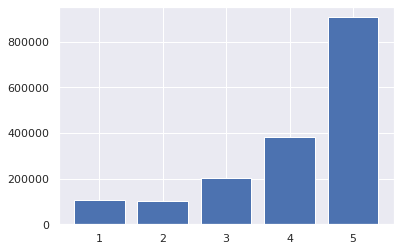

In [74]:
fig, ax = plt.subplots()
ax.bar(df['stars'].value_counts().index,df['overall'].value_counts())

In [99]:
df_first_50k

,_id,reviewerID,asin,reviewerName,reviewText,helpful,overall,summary,unixReviewTime,reviewTime,unicode,lower,remove_punct,no_stopwords,lemmatized
0,607d8d6e4430169e4d014ccc,ADZPIG9QOCDG5,0005019281,"Alice L. Larson ""alice-loves-books""",This is a charming version of the classic Dick...,"[0, 0]",4,good version of a classic,1203984000,"02 26, 2008",This is a charming version of the classic Dick...,this is a charming version of the classic dick...,"[this, is, a, charming, version, of, the, clas...",charming version classic dicken tale henry win...,charming version classic dicken tale henry win...
1,607d8d6e4430169e4d014ccd,A35947ZP82G7JH,0005019281,Amarah Strack,It was good but not as emotionally moving as t...,"[0, 0]",3,Good but not as moving,1388361600,"12 30, 2013",It was good but not as emotionally moving as t...,it was good but not as emotionally moving as t...,"[it, was, good, but, not, as, emotionally, mov...",good emotionally moving christmas carol dicken...,good emotionally moving christmas carol dicken...
2,607d8d6e4430169e4d014cce,A3UORV8A9D5L2E,0005019281,Amazon Customer,"Don't get me wrong, Winkler is a wonderful cha...","[0, 0]",3,Winkler's Performance was ok at best!,1388361600,"12 30, 2013","Don't get me wrong, Winkler is a wonderful cha...","don't get me wrong, winkler is a wonderful cha...","[don, t, get, me, wrong, winkler, is, a, wonde...",get wrong winkler wonderful character actor wo...,get wrong winkler wonderful character actor wo...
3,607d8d6e4430169e4d014ccf,A1VKW06X1O2X7V,0005019281,"Amazon Customer ""Softmill""",Henry Winkler is very good in this twist on th...,"[0, 0]",5,It's an enjoyable twist on the classic story,1202860800,"02 13, 2008",Henry Winkler is very good in this twist on th...,henry winkler is very good in this twist on th...,"[henry, winkler, is, very, good, in, this, twi...",henry winkler good twist classic story convent...,henry winkler good twist classic story convent...
4,607d8d6e4430169e4d014cd0,A3R27T4HADWFFJ,0005019281,BABE,This is one of the best Scrooge movies out. H...,"[0, 0]",4,Best Scrooge yet,1387670400,"12 22, 2013",This is one of the best Scrooge movies out. H...,this is one of the best scrooge movies out. h...,"[this, is, one, of, the, best, scrooge, movies...",one best scrooge movies henry winkler outdoes ...,one best scrooge movie henry winkler outdoes c...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49996,607d8d984430169e4d021018,A2198FZZMTJ38H,0783222734,D. Litton,The novel Jurassic Park gives us a glimpse of ...,"[25, 38]",5,Interestingly spun from the novel.,955497600,"04 12, 2000",The novel Jurassic Park gives us a glimpse of ...,the novel jurassic park gives us a glimpse of ...,"[the, novel, jurassic, park, gives, us, a, gli...",novel jurassic park gives us glimpse could hap...,novel jurassic park give u glimpse could happe...
49997,607d8d984430169e4d021019,A11PTCZ2FM2547,0783222734,"D. Mikels ""It's always Happy Hour here""",Hard to imagine few movies as fun as JURASSIC ...,"[0, 0]",4,"""Life always finds a way. . .""",1315267200,"09 6, 2011",Hard to imagine few movies as fun as JURASSIC ...,hard to imagine few movies as fun as jurassic ...,"[hard, to, imagine, few, movies, as, fun, as, ...",hard imagine movies fun jurassic park fun firs...,hard imagine movie fun jurassic park fun first...
49998,607d8d984430169e4d02101a,A15EW7ZDLT2XZ7,0783222734,Doctor John,So I've owned (and discarded) three previous S...,"[5, 5]",5,Jurassic Park ...redux (again),1364601600,"03 30, 2013",So I've owned (and discarded) three previous S...,so i've owned (and discarded) three previous s...,"[so, i, ve, owned, and, discarded, three, prev...",owned discarded three previous sd dvd editions...,owned discarded three previous sd dvd edition ...
49999,607d8d984430169e4d02101b,A38UHOCEKSUOSP,0783222734,"dominion_ruler ""Bryan""",While I loved almost every aspect of the movie...,"[0, 0]",5,Welcome to Jurassic Park,1200528000,"01 17, 2008",While I loved almost every aspe

In [93]:
balanced_10k_each = pd.concat([one_star_reviews.iloc[:10000], two_star_reviews.iloc[:10000], three_star_reviews.iloc[:10000], four_star_reviews.iloc[:10000], five_star_reviews.iloc[:10000]])
balanced_40k_each = pd.concat([one_star_reviews.iloc[:40000], two_star_reviews.iloc[:40000], three_star_reviews.iloc[:40000], four_star_reviews.iloc[:40000], five_star_reviews.iloc[:40000]])
balanced_10k_each['stars'].value_counts()

5    10000
4    10000
3    10000
2    10000
1    10000
Name: stars, dtype: int64

In [114]:
import nltk
nltk_stopwords = nltk.corpus.stopwords.words('english')
tokenizer = nltk.RegexpTokenizer(r"\w+")

stemmer = nltk.stem.PorterStemmer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def NLP_cleaner_mongodb(pandas_df, collection, document_column_name = 'reviewText'):
    '''
    takes pandas dataframe and inserts entries into mongodb collection with lemmatized text
    '''
    '''
    df = pandas_df
    df['unicode'] = df[document_column_name].str.encode('ascii', 'ignore').str.decode('ascii')
    df['lower'] = df['unicode'].apply(lambda x: x.lower())
    df['remove_punct'] = df['lower'].apply(lambda x: tokenizer.tokenize(x))
    df['no_stopwords'] = df['remove_punct'].apply(lambda x: remove_stopwords(x))
    df['lemmatized'] = df['no_stopwords'].apply(lambda x: lemmatize_text(tokenize(x)))
    '''
    for row_num in range(pandas_df.shape[0]):
        row = (pandas_df.iloc[row_num])
        unicode = row[document_column_name].encode('ascii', 'ignore').decode('ascii')
        lower = unicode.lower()
        remove_punct = tokenize(lower)
        no_stopwords = remove_stopwords(remove_punct)
        lemmatized = lemmatize_text(tokenize(no_stopwords))
        stemmed = stem_text(tokenize(no_stopwords))
        collection.insert_one({'reviewerID': str(row['reviewerID']), 'asin':str(row['asin']), 'reviewerName':row['reviewerName'], 'reviewText': row['reviewText'], 'helpful':row['helpful'], 'overall':str(row['overall']), 'summary':row['summary'], 'unixReviewTime':str(row['unixReviewTime']), 'reviewTime':row['reviewTime'], 'lemmatized':lemmatized, 'stemmed':stemmed})
    
    
    


In [ ]:
NLP_cleaner_mongodb(df, reviews_cleaned)

In [105]:


def remove_punctuation(comment):
    no_punct = [word for word in comment if word not in string.punctuation]
    return ' '.join(no_punct)

def tokenize(comment):
    token = [word.lower() for word in tokenizer.tokenize(comment)]
    return token

def remove_stopwords(comment):
    no_stops_words = [word for word in comment if word not in nltk_stopwords]
    return ' '.join(no_stops_words)

def stem_text(comment):
    stem = [stemmer.stem(word) for word in comment]
    after_stem = ' '.join(stem)
    return after_stem

def lemmatize_text(comment):
    lemma = [lemmatizer.lemmatize(word) for word in comment]
    after_lemma = ' '.join(lemma)
    return after_lemma


In [57]:
df_first_50k = NLP_cleaner(df.loc[:50000, :], 'reviewText')
df_first_10k = NLP_cleaner(df.loc[:10000, :], 'reviewText')
df_first_5k = NLP_cleaner(df.loc[:5000, :], 'reviewText')
df_first_2k = NLP_cleaner(df.loc[:2000, :], 'reviewText')

/home/steven/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/home/steven/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/home/steven/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

In [104]:
multiNB(df_first_50k, 'lemmatized', max_features=1500,max_iter=10000)

/home/steven/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


((0.6064393560643936, 0.43653647607830826, 0.21604907642800725),
 array([[  31,    0,    0,    6,  485],
        [   6,    0,    1,   17,  455],
        [   0,    0,    1,   32,  868],
        [   0,    0,    1,   46, 2052],
        [   0,    0,    0,   13, 5987]]),
 MultinomialNB())

In [95]:
rf_test(balanced_40k_each, max_depth=15)

((0.335025, 0.335025, 0.335025),
 array([[3310, 1408,  505,  428, 2308],
        [2127, 2161, 1002,  717, 1971],
        [1315, 1505, 1390, 1187, 2649],
        [ 936, 1063, 1011, 1514, 3483],
        [ 844,  588,  529, 1023, 5026]]),
 RandomForestClassifier(max_depth=15, n_estimators=10))

In [103]:
def multiNB(pandas_df, text_column='reviewText', max_features = 1500, max_iter = 2000):

    X = pandas_df[text_column]
    y = pandas_df['overall']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

    tvectorizer = TfidfVectorizer(max_features = max_features, strip_accents='ascii', token_pattern=r'(?u)\b\w\w+\b',lowercase=True)
    X_train_tvectorizer = tvectorizer.fit_transform(X_train)
    X_test_tvectorizer = tvectorizer.transform(X_test)


    mnb = MultinomialNB()
    mnb.fit(X_train_tvectorizer, y_train)
    predict = mnb.predict(X_test_tvectorizer)

    a = (accuracy_score(y_test, predict))
    p = (precision_score(y_test, predict, average='macro'))
    r = (recall_score(y_test, predict, average='macro'))

    cm = confusion_matrix(y_test, predict)
    
    return (a,p,r), cm, mnb

In [96]:
def rf_test(pandas_df, text_column = 'reviewText', n_est=10, max_depth = 40, max_feat=None):

    X = pandas_df[text_column]
    y = pandas_df['stars']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

    tvectorizer = TfidfVectorizer(max_features = max_feat, strip_accents='ascii', token_pattern=r'(?u)\b\w\w+\b', stop_words=stopwords.words('english'))
    X_train_tvectorizer = tvectorizer.fit_transform(X_train)
    X_test_tvectorizer = tvectorizer.transform(X_test)
    
    rf = RandomForestClassifier(n_estimators = n_est, max_depth = max_depth)
    rf.fit(X_train_tvectorizer, y_train)
    predict = rf.predict(X_test_tvectorizer)

    a = (accuracy_score(y_test, predict))
    p = (precision_score(y_test, predict, average='micro'))
    r = (recall_score(y_test, predict, average='micro'))

    cm = confusion_matrix(y_test, predict)
    return (a,p,r), cm, rf
